In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
V_w=np.exp(5+0)
print(V_w)

V_ws=(np.exp(5+2)+np.exp(5-2))/2
print(V_ws)

148.4131591025766
558.3593476758231


In [26]:
def integrate_MC(num_points):
    np.random.seed(2022)
    x = np.random.lognormal(size=num_points) 
    return np.mean(np.exp(5+np.log(x)))

print(integrate_MC(num_points))

223.82041490555764


In [28]:
#Det her må være måden at gøre det på. Altså så den måde agenterne tager højde for chokket på er ved 
#at de tager den forventede værdi af de enkelte alternativer. (Som er med chokket inkluderet).
#Denne benytter de så når de beslutter hvad de vil gøre. 

def integrate_MC(f,num_points):
    np.random.seed(2022)
    x = np.random.normal(size=num_points) 
    return np.mean(f+x)

print(integrate_MC(5,num_points))

4.991854538024324


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Nu er det så et fjerde state. Efter det har vi en rigtig model
#Denne her kører. 

#Angiv parameterværdier. 
beta=0.97 #Discount factor

#Scale for shock
sca=5

#Parameterværdier til schooling
C_s=0.0/sca #Constant i schooling
SU_BA=14/sca # Det ændrer hvad man vælger
SU_KA=14/sca
T_S=-0.02/sca
T_Ssq=-0.015

#Parameterværdier til white collar
C_w=0.0/sca #Constant i white_collar
B1w=1.01/sca #Coefficient til HK i white_collar
B2w=0.29/sca #Coefficient til erfaring i white_collar
B3w=-0.005/sca #Coefficient til erfaring^2 i white collar

#Parameterværdier til blue collar
C_b=14.8/sca #Constant i blue collar
B1b=0.1/sca #Coefficient til HK i blue collar
B2b=0.2/sca #Coefficient til erfaring i blue collar
B3b=0.0/sca #Coefficient til erfaring^2 i blue collar

print(C_b)
#Paramterværdier til Home
H=12/sca
T_H=0.08/sca

#B=0.5/sca #Coefficient til humankapital
#C=0.35/sca #Coefficient til erfaring
#K_b=1/sca #Constant til blue collar work
#B_b=0.1/sca #Coefficient til HK, blue collar
#C_b=0.2/sca #Coefficient til egen blue collar erfaring
#H=1.0/sca #Coefficient til at være hjemme.
num_points=100

#Her og nu, en meget meget simpel måde at gøre det på:
#I hver periode tager hver agent bare højde for, at der er et stokastisk chok, 
#til deres nytte hvis de vælger at arbejde. De ved ikke hvad realisationen er men de ved hvad forventningen er.
#Argumentet for det er: De tager bare højde for, at der er usikkerhed, men ikke hvad den usikkerhed er på. 
#Vi behøver ikke behandle det som andet end noget støj fordi de ikke på noget tidspunkt kender realisationerne af det. 
#Det eneste vi måske er nødt til at ændre på er, er at det er for selve værdien af at arbejde der ændres. 
#Det vil sige, at Monte Carloen skal udenom selve V_work.
#Dermed tager man højde for den forventede værdi af de enkelte alternativer.
#Man kunne evt. gøre det ved 
#Initialize:
'''
def integrate_MC(f,num_points):
    np.random.seed(2022)
    x = np.random.normal(size=num_points) 
    return np.mean(f+x)
'''

T=30 #Antal tidsperioder
max_HK=19 #Maksimalt niveau af uddannelse.
max_e=T #Maksimalt niveau af erfaring. Samme som tidsperioder.
max_eb=T #Maksimalt niveau af blue collar erfaring. Samme som tidsperioder. 

#Angiv vektorer med parameter space:
#Skriv nyttefunktioner op: 
#R_w=eC_w + B1w*h + B2w*e + B3w*e^2 + eps_w
#Ide=exp{C_w + B1w*log(h) + B2w*log(e) + B3w*log(e)^2} + eps_w
#R_s = C_s + SU1*I[13<h<17] + SU2*I[h>=17] + eps_s
#R_h = C_h + eps_h

#Generer min expected value function. Nu skal den have en ekstra dimension.

maxV = np.nan+np.zeros([max_HK,max_e,max_eb,T])
ev0 = np.nan+np.zeros([max_HK,max_e,max_eb,T]) #Generer expected value function med ekstra dimension (første er hk, anden er erfaring, så kommer blue collar erfaring, sidste er tid)
#print(ev0) #Tid er kolonner, blue_erfaring er rækker, stor matrix er HK, lille matrix erfaring
pk_w = np.nan+np.zeros([max_HK,max_e,max_eb,T]) # Choice prob for choosing work
pk_b = np.nan+np.zeros([max_HK,max_e,max_eb,T]) #Choice prob for choosing blue collar
pk_s = np.nan+np.zeros([max_HK,max_e,max_eb,T]) # Choice prob for choosing school
V_school=np.nan+np.zeros([max_HK,max_e,max_eb,T]) # Choice specific value functions
V_work=np.nan+np.zeros([max_HK,max_e,max_eb,T]) # Choice specific value functions
V_home=np.nan+np.zeros([max_HK,max_e,max_eb,T]) # Choice specific value functions
V_blue=np.nan+np.zeros([max_HK,max_e,max_eb,T]) # Choice specific value functions

#Nu genererer jeg expected value i last period for hver af de enkelte valg:
for h in range(max_HK):
    for e in range(max_e):
        for eb in range(max_eb):
            BA_stud=13<h<17
            KA_stud=h>=17
            V_school[h,e,eb,T-1]=SU_BA*BA_stud+SU_KA*KA_stud+T_S*(T-1)+T_Ssq*(T-1)**2# Last period value from schooling
#print(V_school)

#V_school[:,:,:,T-1]=SU1
for h in range(max_HK):
    for e in range(max_e):
        for eb in range(max_eb):
            np.random.seed(2022)
            eta_eT = np.random.normal(size=num_points)
            V_work[h,e,eb,T-1]=np.mean((C_w + B1w*h +B2w*e + B3w*e**2+eta_eT))

for h in range(max_HK):
    for e in range(max_e):
        for eb in range(max_eb):
            np.random.seed(2022)
            eta_bT = np.random.normal(size=num_points)
            V_blue[h,e,eb,T-1]=np.mean(C_b + B1b*h + B2b*eb + B3b*eb**2+eta_bT)


            
V_home[:,:,:,T-1]=H+T_H*(T-1)

#print(H)

maxV[:,:,:,T-1]=np.maximum.reduce([V_work[:,:,:,T-1],V_school[:,:,:,T-1],V_home[:,:,:,T-1],V_blue[:,:,:,T-1]])
#print(ev0)
ev0[:,:,:,T-1]=maxV[:,:,:,T-1] + np.log(np.exp(V_work[:,:,:,T-1]-maxV[:,:,:,T-1])+np.exp(V_school[:,:,:,T-1]-maxV[:,:,:,T-1])+np.exp(V_blue[:,:,:,T-1]-maxV[:,:,:,T-1])+np.exp(V_home[:,:,:,T-1]-maxV[:,:,:,T-1]))
#pk_w[:,:,:,T-1]=ev0[:,:,:,T-1]==V_work[:,:,:,T-1] #Uden stokastik
pk_w[:,:,:,T-1]=np.exp(V_work[:,:,:,T-1])/(np.exp(V_school[:,:,:,T-1])+np.exp(V_work[:,:,:,T-1])+np.exp(V_home[:,:,:,T-1])+np.exp(V_blue[:,:,:,T-1])) # MED EV1 error terms er det logit form expression.
#pk_s[:,:,:,T-1]=ev0[:,:,:,T-1]==V_school[:,:,:,T-1] #Uden stokastik
pk_s[:,:,:,T-1]=np.exp(V_school[:,:,:,T-1])/(np.exp(V_school[:,:,:,T-1])+np.exp(V_work[:,:,:,T-1])+np.exp(V_home[:,:,:,T-1])+np.exp(V_blue[:,:,:,T-1])) # MED EV1 error terms er det logit form expression.
#pk_b[:,:,:,T-1]=ev0[:,:,:,T-1]==V_blue[:,:,:,T-1] #Uden stokastik
pk_b[:,:,:,T-1]=np.exp(V_blue[:,:,:,T-1])/(np.exp(V_school[:,:,:,T-1])+np.exp(V_work[:,:,:,T-1])+np.exp(V_home[:,:,:,T-1])+np.exp(V_blue[:,:,:,T-1])) # MED EV1 error terms er det logit form expression.


for t in range(T-2, -1, -1): #Solve backwards from period T-1(2??), until period 0, backwards
    for h in range(max_HK):
        for ex in range(max_e):
            for e_b in range(max_eb):
                BA_stud=13<h<17
                KA_stud=h>=17
                np.random.seed(2022)
                eta_e = np.random.normal(size=num_points)
                eta_b = np.random.normal(size=num_points)
                V_school[h,ex,e_b,t]=SU_BA*BA_stud+SU_KA*KA_stud +T_S*t+T_Ssq*t**2 + beta*ev0[np.minimum(h+1,max_HK-1),ex,e_b,t+1] #Denne viser værdien af skole som er, værdien af SU samt den forventede value function hvor vi opdaterer hk., i t+1
                #Dem der kommer nu og muligvis også den ovenover, her skal vi have eps. shocks ind. Den skal være inde i ev. Desuden skal vi også have dem i selve nytten. 
                #Så det vil sige, at de tager højde for usikkerheden nu OG i fremtiden. 
                V_work[h,ex,e_b,t]= np.mean(C_w + B1w*h +B2w*ex + B3w*ex**2 + eta_e) + beta*ev0[h,np.minimum(ex+1,max_e-1),e_b,t+1] #Denne viser værdien af work som er lig state space matricen evalueret der hvor vi er + den forventede value function i periode t+1
                V_blue[h,ex,e_b,t]= np.mean(C_b + B1b*h + B2b*e_b + B3b*e_b**2+eta_b)+beta*ev0[h,ex,np.minimum(e_b+1,max_eb-1),t+1] # Værdien af blue collar work
                V_home[h,ex,e_b,t]=H + T_H*t + beta*ev0[h,ex,e_b,t+1] #Denne viser værdien af home.
                maxV[h,ex,e_b,t]=np.maximum.reduce([V_work[h,ex,e_b,t],V_school[h,ex,e_b,t],V_home[h,ex,e_b,t],V_blue[h,ex,e_b,t]]) #Denne viser expected value function som er lig den maksimale værdi vi får fra den chocie specific value fct.
                ev0[h,ex,e_b,t]=maxV[h,ex,e_b,t]+np.log(np.exp(V_work[h,ex,e_b,t]-maxV[h,ex,e_b,t])+np.exp(V_school[h,ex,e_b,t]-maxV[h,ex,e_b,t])+np.exp(V_blue[h,ex,e_b,t]-maxV[h,ex,e_b,t])+np.exp(V_home[h,ex,e_b,t]-maxV[h,ex,e_b,t]))
                #pk_w[h,ex,e_b,t]=ev0[h,ex,e_b,t]==V_work[h,ex,e_b,t] #Uden stokastik
                #pk_s[h,ex,e_b,t]=ev0[h,ex,e_b,t]==V_school[h,ex,e_b,t]
                #pk_b[h,ex,e_b,t]=ev0[h,ex,e_b,t]==V_blue[h,ex,e_b,t]
                pk_w[h,ex,e_b,t]=np.exp(V_work[h,ex,e_b,t])/(np.exp(V_school[h,ex,e_b,t])+np.exp(V_work[h,ex,e_b,t])+np.exp(V_home[h,ex,e_b,t])+np.exp(V_blue[h,ex,e_b,t])) # computer choice probabilities som er closed form når det er logit.
                pk_s[h,ex,e_b,t]=np.exp(V_school[h,ex,e_b,t])/(np.exp(V_school[h,ex,e_b,t])+np.exp(V_work[h,ex,e_b,t])+np.exp(V_home[h,ex,e_b,t])+np.exp(V_blue[h,ex,e_b,t])) # computer choice probabilities som er closed form når det er logit.
                pk_s[h,ex,e_b,t]=np.exp(V_blue[h,ex,e_b,t])/(np.exp(V_school[h,ex,e_b,t])+np.exp(V_work[h,ex,e_b,t])+np.exp(V_home[h,ex,e_b,t])+np.exp(V_blue[h,ex,e_b,t])) # computer choice probabilities som er closed form når det er logit.
    
    #print(pk)

#print(hk)
#print(pk_w)
#print(pk_s)
#print(pk_b)
#print(V_school)
#print(V_work)
#print(V_home)
#print(V_blue)
#print(ev0) 

#Næste steps:
#Gennemgå koden. Se om den er okay/rigtig. 
#Mangler nok stadig noget stokasticitet i form af expected max i nuværende periode (mangler logsum)
#Se nfxp forelæsning omkring slide 16.
#Så problemet er, at jeg ikke tager højde for i udregningen af ev0, at der også er fejlled og at man 
#kan tage dem og dermed de bedste trækninger med i nytteberegningen. 
#Så logsum er en konsekvens af EV1 præferenceshocks. --> Smooth/integrated value function.
#Derudover kan der være specifikke lønshocks som stadig skal integreres.
#Simulér data for den store model. 
#Estimér modellen. 



2.96


       dw     db     ds     dh
0   172.0  329.0  393.0  106.0
1   168.0  315.0  422.0   95.0
2   195.0  344.0  370.0   91.0
3   222.0  304.0  375.0   99.0
4   249.0  311.0  340.0  100.0
5   273.0  329.0  298.0  100.0
6   286.0  348.0  261.0  105.0
7   326.0  365.0  196.0  113.0
8   323.0  396.0  159.0  122.0
9   376.0  391.0  109.0  124.0
10  388.0  423.0   69.0  120.0
11  401.0  412.0   48.0  139.0
12  412.0  400.0   46.0  142.0
13  439.0  406.0   25.0  130.0
14  444.0  417.0   17.0  122.0
15  413.0  426.0   13.0  148.0
16  421.0  434.0    7.0  138.0
17  406.0  443.0    7.0  144.0
18  443.0  411.0    2.0  144.0
19  420.0  406.0    1.0  173.0
20  425.0  426.0    0.0  149.0
21  415.0  426.0    0.0  159.0
22  434.0  413.0    0.0  153.0
23  401.0  445.0    0.0  154.0
24  417.0  424.0    0.0  159.0
25  406.0  428.0    0.0  166.0
26  419.0  430.0    0.0  151.0
27  408.0  439.0    0.0  153.0
28  406.0  427.0    0.0  167.0
29  408.0  430.0    0.0  162.0


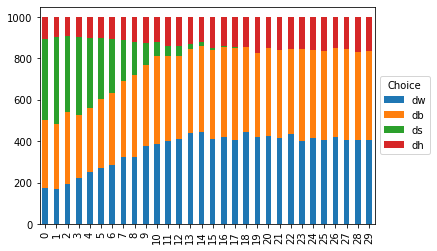

In [33]:
np.random.seed(2021)

N=1000 #Amount of people to simulate. 
idx = np.tile(np.arange(1,N+1),(T,1))  # Index
t = np.tile(np.arange(1,T+1),(N,1)).T # Tidsperiode for hvert individ.
s = 1.0
m= 0.0

h=np.zeros([T,N]) # hk state for all the simulated people in all the simulated time. 
h1=np.zeros([T,N]) # hk state for all the simulated people in all the simulated time. 
e=np.zeros([T,N]) # Experience state for all the simulated people in all simulated time.
e1=np.zeros([T,N])
b=np.zeros([T,N])
b1=np.zeros([T,N])
dw=np.nan + np.zeros((T,N)) # decisions for all people. 1 = work, 0 = school.
db=np.nan + np.zeros((T,N))
ds=np.nan + np.zeros((T,N)) # decisions for all people. 1 = work, 0 = school.
dh=np.nan + np.zeros((T,N))
u_inith=13
u_inite=0
u_initb=0
u_s=np.zeros((T,N))
u_w=np.zeros((T,N))
u_b=np.zeros((T,N))
u_h=np.zeros((T,N))
u_init=0

for n in range(N):
    for tt in range(T):
        u_s[tt,n]=np.random.gumbel(loc=m, scale=s, size=None)
        u_w[tt,n]=np.random.gumbel(loc=m, scale=s, size=None)
        u_b[tt,n]=np.random.gumbel(loc=m, scale=s, size=None)
        u_h[tt,n]=np.random.gumbel(loc=m, scale=s, size=None)
 # Fejlled for schooling
#u_w=np.random.rand(T,N) # Fejlled for work
#u_b=np.random.rand(T,N) # Fejlled for home
#u_h=np.random.rand(T,N) # Fejlled for home
#pks=np.zeros([max_HK,N,T])
#print(pks)
h[0,:]=u_inith # First state variable. 
e[0,:]=u_init # First state variable.
b[0,:]=u_init # First state variable.

#+V_school[int(x[it,n]),it]
for n in range(N):
    for it in range(T):
        dw[it,n] = np.maximum.reduce([V_school[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_s[it,n],V_work[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_w[it,n],V_home[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_h[it,n],V_blue[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_b[it,n]])==V_work[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_w[it,n]
        ds[it,n] = np.maximum.reduce([V_school[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_s[it,n],V_work[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_w[it,n],V_home[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_h[it,n],V_blue[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_b[it,n]])==V_school[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_s[it,n]
        db[it,n] = np.maximum.reduce([V_school[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_s[it,n],V_work[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_w[it,n],V_home[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_h[it,n],V_blue[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_b[it,n]])==V_blue[int(h[it,n]),int(e[it,n]),int(b[it,n]),it]+u_b[it,n]
        dh[it,n] = 1-ds[it,n]-dw[it,n]-db[it,n]
        h1[it,n] = np.minimum(h[it,n]+ds[it,n],max_HK-1)
        e1[it,n] = np.minimum(e[it,n]+dw[it,n],max_e-1)
        b1[it,n] = np.minimum(b[it,n]+db[it,n],max_eb-1)
        if it < T-1:
            h[it+1,n] = h1[it,n]
            e[it+1,n] = e1[it,n]
            b[it+1,n] = b1[it,n]

[max_HK,max_e,max_eb,T]
            
idx =  np.reshape(idx,T*N,order='F')
t = np.reshape(t,T*N,order='F')
dw = np.reshape(dw,T*N,order='F')
ds = np.reshape(ds,T*N,order='F')
db = np.reshape(db,T*N,order='F')
dh = np.reshape(dh,T*N,order='F')
h = np.reshape(h,T*N,order='F')
h1 = np.reshape(h1,T*N,order='F')
e = np.reshape(e,T*N,order='F')
e1 = np.reshape(e1,T*N,order='F')
b = np.reshape(b,T*N,order='F')
b1 = np.reshape(b1,T*N,order='F')
#dx1 = np.reshape(dx1,T*N,order='F')


data = {'id': idx,'t': t, 'dw': dw, 'ds': ds, 'db': db, 'dh': dh, 'h': h, 'h1': h1, 'e': e, 'e1': e1, 'b': b, 'b1': b1}
df= pd.DataFrame(data)

pivot = pd.pivot_table(data=df, index=['t'], values=['dw', 'ds', 'db', 'dh'], aggfunc='count')
pivot

df1=df.groupby('t', as_index=False).agg({"dw": "sum", "db": "sum", "ds": "sum",  "dh": "sum"})

df1.drop('t', axis=1, inplace=True)
print(df1)
#Liste:

df1.plot.bar(stacked=True)
plt.legend(title='Choice', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


    dw   db   ds      dh
0  0.0  0.0  0.0  1000.0
1  0.0  0.0  0.0  1000.0
2  0.0  0.0  0.0  1000.0
3  0.0  0.0  0.0  1000.0
4  0.0  0.0  0.0  1000.0
5  0.0  0.0  0.0  1000.0
6  0.0  0.0  0.0  1000.0
7  0.0  0.0  0.0  1000.0
8  0.0  0.0  0.0  1000.0
9  0.0  0.0  0.0  1000.0


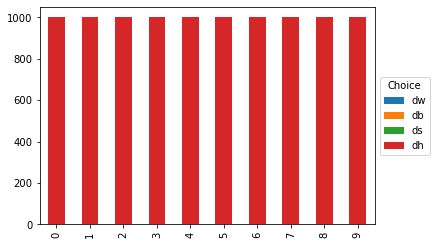

In [11]:
pivot = pd.pivot_table(data=df, index=['t'], values=['dw', 'ds', 'db', 'dh'], aggfunc='count')
pivot

df1=df.groupby('t', as_index=False).agg({"dw": "sum", "db": "sum", "ds": "sum",  "dh": "sum"})

df1.drop('t', axis=1, inplace=True)
print(df1)
#Liste:

df1.plot.bar(stacked=True)
plt.legend(title='Choice', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
